In [1]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, AdamW
from transformers import DataCollatorForTokenClassification
from datasets import load_dataset
from accelerate import Accelerator
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from peft import LoraConfig, TaskType, PeftModel, PeftConfig, get_peft_model, prepare_model_for_kbit_training

# Load the tokenizer with add_prefix_space=True for compatibility with pre-tokenized inputs
tokenizer = AutoTokenizer.from_pretrained('roberta-base', add_prefix_space=True)

# Function to tokenize and align labels for the NER dataset
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding="max_length", is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Maps tokens to their word in the input sequences
        label_ids = np.ones(len(tokenized_inputs["input_ids"][i]), dtype=int) * -100  # Initialize labels to -100
        for word_idx, label in zip(word_ids, examples["ner_tags"][i]):
            if word_idx is not None:  # Set labels for words (not subtokens)
                label_ids[word_idx] = label
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Load and preprocess the dataset using the correct path
dataset = load_dataset("DFKI-SLT/few-nerd", "supervised")
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=dataset["train"].column_names)
tokenized_datasets["train"] = tokenized_datasets["train"].train_test_split(test_size=128)["test"]
tokenized_datasets["validation"] = tokenized_datasets["train"].train_test_split(test_size=32)["test"]
tokenized_datasets["test"] = tokenized_datasets["train"].train_test_split(test_size=40)["test"]
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 128
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 32
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 40
    })
})

In [2]:
# Prepare data collator for padding and labels
data_collator = DataCollatorForTokenClassification(tokenizer)

# Load the model configured for NER with the appropriate number of labels
model = AutoModelForTokenClassification.from_pretrained('roberta-base', num_labels=len(dataset["train"].features["ner_tags"].feature.names))

# peft model
config = LoraConfig(
    # GUIDE   => https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft
    # https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft:~:text=use_rslora%3A%20When%20set%20to%20True%2C%20uses%20Rank%2DStabilized%20LoRA%20which%20sets%20the%20adapter%20scaling%20factor
    # https://arxiv.org/abs/2312.03732, 
    r = 2,
    target_modules=["query", "key", "value"],
    bias="all",
    use_rslora=True,
    task_type=TaskType.TOKEN_CLS,
    lora_dropout=0.1
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, config)
type(model)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


peft.peft_model.PeftModelForTokenClassification

/home/matthias/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch: 1, Step: 0, Loss: 2.1465160846710205
Epoch: 1, Step: 10, Loss: 2.1731700897216797
Epoch: 1, Step: 20, Loss: 2.174635887145996
Epoch: 1, Step: 30, Loss: 2.115023136138916
Epoch: 1, Step: 40, Loss: 2.214600086212158
Epoch: 1, Step: 50, Loss: 2.074392318725586
Epoch: 1, Step: 60, Loss: 2.004371166229248
Epoch: 1, Step: 70, Loss: 1.9958134889602661
Epoch: 1, Step: 80, Loss: 1.9594640731811523
Epoch: 1, Step: 90, Loss: 2.1686909198760986
Epoch: 1, Step: 100, Loss: 1.993504285812378
Epoch: 1, Step: 110, Loss: 2.0826914310455322
Epoch: 1, Step: 120, Loss: 2.208746910095215
Epoch: 2, Step: 0, Loss: 2.018195867538452
Epoch: 2, Step: 10, Loss: 1.97550368309021
Epoch: 2, Step: 20, Loss: 1.7529724836349487
Epoch: 2, Step: 30, Loss: 1.9683750867843628
Epoch: 2, Step: 40, Loss: 1.8380258083343506
Epoch: 2, Step: 50, Loss: 1.6762034893035889
Epoch: 2, Step: 60, Loss: 1.5562989711761475
Epoch: 2, Step: 70, Loss: 1.9177085161209106
Epoch: 2, Step: 80, Loss: 1.8564139604568481
Epoch: 2, Step: 90,

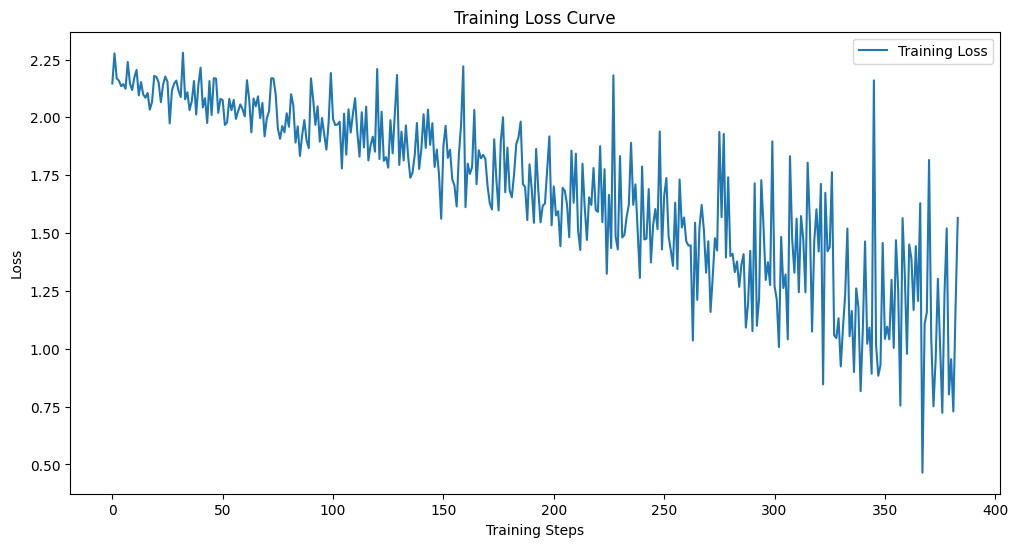

In [3]:
# Setup DataLoader
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=1, collate_fn=data_collator)

# Prepare for training with the Accelerate library
accelerator = Accelerator()
optimizer = AdamW(model.parameters(), lr=1e-5)

model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

# Initialize the list to store loss values
loss_values = []

# Training loop
for epoch in range(3):  # Adjust the number of epochs as needed
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**{k: v.to(accelerator.device) for k, v in batch.items()})
        loss = outputs.loss
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
        loss_values.append(accelerator.gather(loss.repeat(1)).mean().item())
        if step % 10 == 0:
            print(f"Epoch: {epoch + 1}, Step: {step}, Loss: {loss.item()}")

# Plot the loss curve
plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()